In [130]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from xgboost import XGBClassifier
from datetime import datetime

In [131]:
df = pd.read_csv('../data/coffee_cleaned.csv')
df["datetime"] = pd.to_datetime(df["datetime"])

In [132]:
df['categoria_cafe'] = 'Outros'
df.loc[df['coffee_name'].isin(['Americano', 'Espresso']), 'categoria_cafe'] = 'Café Preto'
df.loc[df['coffee_name'].isin(['Latte', 'Cappuccino', 'Cortado', 'Americano with Milk']), 'categoria_cafe'] = 'Café com Leite'
df.loc[df['coffee_name'].isin(['Hot Chocolate', 'Cocoa']), 'categoria_cafe'] = 'Chocolate Quente'

df = df[df['categoria_cafe'] != 'Outros'].copy()

In [133]:
df['hour_float'] = df['datetime'].dt.hour + df['datetime'].dt.minute / 60
df['day_of_week'] = df['datetime'].dt.dayofweek
df['is_weekend'] = (df['day_of_week'] >= 5).astype(int)

angle = 2 * np.pi * df['hour_float'] / 24
df['hour_sin'] = np.sin(angle)
df['hour_cos'] = np.cos(angle)

df['is_choc'] = (df['categoria_cafe'] == 'Chocolate Quente').astype(int)
df['is_milk'] = (df['categoria_cafe'] == 'Café com Leite').astype(int)
df['is_black'] = (df['categoria_cafe'] == 'Café Preto').astype(int)

df['weather'] = df['weather'].fillna('unknown')
df = pd.get_dummies(df, columns=['weather'], prefix='weather')
weather_cols = [c for c in df.columns if c.startswith('weather_')]

base_features = ['hour_float', 'day_of_week', 'is_weekend', 'hour_sin', 'hour_cos'] + weather_cols

train_df, test_df = train_test_split(
    df,
    test_size=0.3,
    random_state=42,
    stratify=df['categoria_cafe']
)

In [134]:
card_stats = train_df.groupby('card')[['is_choc', 'is_milk', 'is_black']].mean().reset_index()
card_stats = card_stats.rename(columns={
    'is_choc': 'card_choc_rate',
    'is_milk': 'card_milk_rate',
    'is_black': 'card_black_rate'
})

train_df = train_df.merge(card_stats, on='card', how='left')
test_df = test_df.merge(card_stats, on='card', how='left')

global_rates = train_df[['card_choc_rate', 'card_milk_rate', 'card_black_rate']].mean()
train_df[['card_choc_rate', 'card_milk_rate', 'card_black_rate']] = train_df[['card_choc_rate', 'card_milk_rate', 'card_black_rate']].fillna(global_rates)
test_df[['card_choc_rate', 'card_milk_rate', 'card_black_rate']] = test_df[['card_choc_rate', 'card_milk_rate', 'card_black_rate']].fillna(global_rates)

features = base_features + ['card_choc_rate', 'card_milk_rate', 'card_black_rate']


In [135]:
X1_train = train_df[features]
y1_train = train_df['is_choc']
w1_train = compute_sample_weight(class_weight='balanced', y=y1_train)

model_choc = XGBClassifier(
    max_depth=4,
    learning_rate=0.05,
    n_estimators=300,
    subsample=0.9,
    colsample_bytree=0.9,
    random_state=42,
    eval_metric='logloss'
)
model_choc.fit(X1_train, y1_train, sample_weight=w1_train)

,"objective objective: str | xgboost.sklearn._SklObjWProto | typing.Callable[[typing.Any, typing.Any], typing.Tuple[numpy.ndarray, numpy.ndarray]] | NoneSpecify the learning task and the corresponding learning objective or a customobjective function to be used.For custom objective, see :doc:`/tutorials/custom_metric_obj` and:ref:`custom-obj-metric` for more information, along with the end note forfunction signatures.",'binary:logistic'
,"base_score base_score: float | typing.List[float] | NoneThe initial prediction score of all instances, global bias.",None
,booster,None
,"callbacks callbacks: typing.List[xgboost.callback.TrainingCallback] | NoneList of callback functions that are applied at end of each iteration.It is possible to use predefined callbacks by using:ref:`Callback API `... note:: States in callback are not preserved during training, which means callback objects can not be reused for multiple training sessions without reinitialization or deepcopy... code-block:: python for params in parameters_grid: # be sure to (re)initialize the callbacks before each run callbacks = [xgb.callback.LearningRateScheduler(custom_rates)] reg = xgboost.XGBRegressor(**params, callbacks=callbacks) reg.fit(X, y)",None
,colsample_bylevel colsample_bylevel: float | NoneSubsample ratio of columns for each level.,None
,colsample_bynode colsample_bynode: float | NoneSubsample ratio of columns for each split.,None
,colsample_bytree colsample_bytree: float | NoneSubsample ratio of columns when constructing each tree.,0.9
,"device device: str | None.. versionadded:: 2.0.0Device ordinal, available options are `cpu`, `cuda`, and `gpu`.",None
,"early_stopping_rounds early_stopping_rounds: int | None.. versionadded:: 1.6.0- Activates early stopping. Validation metric needs to improve at least once in every **early_stopping_rounds** round(s) to continue training. Requires at least one item in **eval_set** in :py:meth:`fit`.- If early stopping occurs, the model will have two additional attributes: :py:attr:`best_score` and :py:attr:`best_iteration`. These are used by the :py:meth:`predict` and :py:meth:`apply` methods to determine the optimal number of trees during inference. If users want to access the full model (including trees built after early stopping), they can specify the `iteration_range` in these inference methods. In addition, other utilities like model plotting can also use the entire model.- If you prefer to discard the trees after `best_iteration`, consider using the callback function :py:class:`xgboost.callback.EarlyStopping`.- If there's more than one item in **eval_set**, the last entry will be used for early stopping. If there's more than one metric in **eval_metric**, the last metric will be used for early stopping.",None
,enable_categorical enable_categorical: boolSee the same parameter of :py:class:`DMatrix` for details.,False
,"eval_metric eval_metric: str | typing.List[str | typing.Callable] | typing.Callable | None.. versionadded:: 1.6.0Metric used for monitoring the training result and early stopping. It can be astring or list of strings as names of predefined metric in XGBoost (See:doc:`/parameter`), one of the metrics in :py:mod:`sklearn.metrics`, or anyother user defined metric that looks like `sklearn.metrics`.If custom objective is also provided, then custom metric should implement thecorresponding reverse link function.Unlike the `scoring` parameter commonly used in scikit-learn, when a callableobject is provided, it's assumed to be a cost function and by default XGBoostwill minimize the result during early stopping.For advanced usage on Early stopping like directly choosing to maximize insteadof minimize, see :py:obj:`xgboost.callback.EarlyStopping`.See :doc:`/tutorials/custom_metric_obj` and :ref:`custom-obj-metric` for moreinformation... code-block:: python from sklearn.datasets import load_diabetes from sklearn.metrics import mean_absolute_error X, y = load_diabetes(return_X_y=True) reg = xgb.XGBRegressor( tree_metho

In [136]:
train_coffee = train_df[train_df['is_choc'] == 0]

X2_train = train_coffee[features]
y2_train = train_coffee['is_milk']
w2_train = compute_sample_weight(class_weight='balanced', y=y2_train)

model_milk = XGBClassifier(
    max_depth=4,
    learning_rate=0.05,
    n_estimators=300,
    subsample=0.9,
    colsample_bytree=0.9,
    random_state=42,
    eval_metric='logloss'
)
model_milk.fit(X2_train, y2_train, sample_weight=w2_train)

,"objective objective: str | xgboost.sklearn._SklObjWProto | typing.Callable[[typing.Any, typing.Any], typing.Tuple[numpy.ndarray, numpy.ndarray]] | NoneSpecify the learning task and the corresponding learning objective or a customobjective function to be used.For custom objective, see :doc:`/tutorials/custom_metric_obj` and:ref:`custom-obj-metric` for more information, along with the end note forfunction signatures.",'binary:logistic'
,"base_score base_score: float | typing.List[float] | NoneThe initial prediction score of all instances, global bias.",None
,booster,None
,"callbacks callbacks: typing.List[xgboost.callback.TrainingCallback] | NoneList of callback functions that are applied at end of each iteration.It is possible to use predefined callbacks by using:ref:`Callback API `... note:: States in callback are not preserved during training, which means callback objects can not be reused for multiple training sessions without reinitialization or deepcopy... code-block:: python for params in parameters_grid: # be sure to (re)initialize the callbacks before each run callbacks = [xgb.callback.LearningRateScheduler(custom_rates)] reg = xgboost.XGBRegressor(**params, callbacks=callbacks) reg.fit(X, y)",None
,colsample_bylevel colsample_bylevel: float | NoneSubsample ratio of columns for each level.,None
,colsample_bynode colsample_bynode: float | NoneSubsample ratio of columns for each split.,None
,colsample_bytree colsample_bytree: float | NoneSubsample ratio of columns when constructing each tree.,0.9
,"device device: str | None.. versionadded:: 2.0.0Device ordinal, available options are `cpu`, `cuda`, and `gpu`.",None
,"early_stopping_rounds early_stopping_rounds: int | None.. versionadded:: 1.6.0- Activates early stopping. Validation metric needs to improve at least once in every **early_stopping_rounds** round(s) to continue training. Requires at least one item in **eval_set** in :py:meth:`fit`.- If early stopping occurs, the model will have two additional attributes: :py:attr:`best_score` and :py:attr:`best_iteration`. These are used by the :py:meth:`predict` and :py:meth:`apply` methods to determine the optimal number of trees during inference. If users want to access the full model (including trees built after early stopping), they can specify the `iteration_range` in these inference methods. In addition, other utilities like model plotting can also use the entire model.- If you prefer to discard the trees after `best_iteration`, consider using the callback function :py:class:`xgboost.callback.EarlyStopping`.- If there's more than one item in **eval_set**, the last entry will be used for early stopping. If there's more than one metric in **eval_metric**, the last metric will be used for early stopping.",None
,enable_categorical enable_categorical: boolSee the same parameter of :py:class:`DMatrix` for details.,False
,"eval_metric eval_metric: str | typing.List[str | typing.Callable] | typing.Callable | None.. versionadded:: 1.6.0Metric used for monitoring the training result and early stopping. It can be astring or list of strings as names of predefined metric in XGBoost (See:doc:`/parameter`), one of the metrics in :py:mod:`sklearn.metrics`, or anyother user defined metric that looks like `sklearn.metrics`.If custom objective is also provided, then custom metric should implement thecorresponding reverse link function.Unlike the `scoring` parameter commonly used in scikit-learn, when a callableobject is provided, it's assumed to be a cost function and by default XGBoostwill minimize the result during early stopping.For advanced usage on Early stopping like directly choosing to maximize insteadof minimize, see :py:obj:`xgboost.callback.EarlyStopping`.See :doc:`/tutorials/custom_metric_obj` and :ref:`custom-obj-metric` for moreinformation... code-block:: python from sklearn.datasets import load_diabetes from sklearn.metrics import mean_absolute_error X, y = load_diabetes(return_X_y=True) reg = xgb.XGBRegressor( tree_metho

In [137]:
labels = np.array(['Café Preto', 'Café com Leite', 'Chocolate Quente'])

X_test = test_df[features]
p_choc = model_choc.predict_proba(X_test)[:, 1]
p_milk_given_coffee = model_milk.predict_proba(X_test)[:, 1]

p_coffee = 1 - p_choc
p_milk = p_coffee * p_milk_given_coffee
p_black = p_coffee * (1 - p_milk_given_coffee)

probs = np.vstack([p_black, p_milk, p_choc]).T

y_true = test_df['categoria_cafe'].values
y_pred = labels[np.argmax(probs, axis=1)]

comparacao = pd.DataFrame({'Real': y_true, 'Predição': y_pred})
display(comparacao.head(25))

,Real,Predição
0,Café Preto,Café Preto
1,Café Preto,Café Preto
2,Café com Leite,Chocolate Quente
3,Café com Leite,Café com Leite
4,Café Preto,Chocolate Quente
5,Café com Leite,Café com Leite
6,Café com Leite,Chocolate Quente
7,Café Preto,Café Preto
8,Chocolate Quente,Chocolate Quente
9,Café com Leite,Chocolate Quente


In [138]:
print(classification_report(y_true, y_pred, labels=labels))

                  precision    recall  f1-score   support

      Café Preto       0.47      0.66      0.55       214
  Café com Leite       0.87      0.60      0.71       720
Chocolate Quente       0.33      0.62      0.43       157

        accuracy                           0.61      1091
       macro avg       0.56      0.63      0.56      1091
    weighted avg       0.71      0.61      0.64      1091



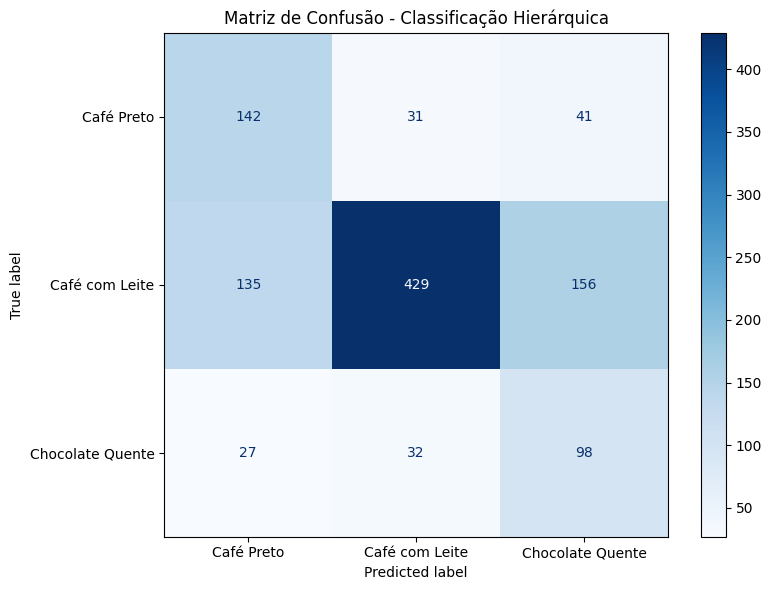

In [139]:
fig, ax = plt.subplots(figsize=(8, 6))
ConfusionMatrixDisplay.from_predictions(
    y_true,
    y_pred,
    labels=labels,
    ax=ax,
    cmap='Blues',
    xticks_rotation=0
)
plt.title('Matriz de Confusão - Classificação Hierárquica')
plt.tight_layout()
plt.show()